In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package
sys.path.append("../../..")

# Third party imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.metrics.report import ClassificationReport
from librep.estimators import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport

from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder


from librep.transforms import UMAP
from tabulate import tabulate

2022-10-25 14:55:32.612464: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 14:55:32.612484: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from Experiments_topoae_KuHar20Hz_helper import *
kuhar_data = obtainKuHar20Hz()
train_HD = kuhar_data['train_HD']
train_LD = kuhar_data['train_LD']
train_Y = kuhar_data['train_Y']
test_HD = kuhar_data['test_HD']
test_LD = kuhar_data['test_LD']
test_Y = kuhar_data['test_Y']

# Preparing Table

Columns:
* RF (Accuracy, F1)
* SVC (Accuracy, F1)
* KNN (Accuracy, F1)
* Trustworthiness
* Continuity
* Co-k-nearest-neighbor-size

Rows:
* UMAP (2 dim)
* Generic Autoencoders
* Topological autoencoders (L=1)
* Topological autoencoders (L=100)

In [5]:
def print_table(table_info):
    tabulated = tabulate(
        table_info,
        headers='keys',
        tablefmt='fancy_grid',
        missingval='-'
    )
    print(tabulated)


table_info = {
    'Metrics': ['RF-ACC', 'RF-F1',
                'SVC-ACC', 'SVC-F1',
                'KNN-ACC', 'KNN-F1',
                'Trustworthiness',
                'Continuity',
                'Co-k-NNs'],
    'UMAP': ['-']*9,
    'Generic-AE': ['-']*9,
    'Topo-AEv2 (L=1000)': ['-']*9,
    'Topo-AEv2 (L=10000)': ['-']*9,
    'M-AE (L=1000)': ['-']*9,
    'M-AE (L=10000)': ['-']*9
}
print_table(table_info)

╒═════════════════╤════════╤══════════════╤══════════════════════╤═══════════════════════╤═════════════════╤══════════════════╕
│ Metrics         │ UMAP   │ Generic-AE   │ Topo-AEv2 (L=1000)   │ Topo-AEv2 (L=10000)   │ M-AE (L=1000)   │ M-AE (L=10000)   │
╞═════════════════╪════════╪══════════════╪══════════════════════╪═══════════════════════╪═════════════════╪══════════════════╡
│ RF-ACC          │ -      │ -            │ -                    │ -                     │ -               │ -                │
├─────────────────┼────────┼──────────────┼──────────────────────┼───────────────────────┼─────────────────┼──────────────────┤
│ RF-F1           │ -      │ -            │ -                    │ -                     │ -               │ -                │
├─────────────────┼────────┼──────────────┼──────────────────────┼───────────────────────┼─────────────────┼──────────────────┤
│ SVC-ACC         │ -      │ -            │ -                    │ -                     │ -            

# Visualization helper

In [6]:
def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

# Applying Scaler

MinMaxScaler, MaxAbsScaler and StandardScaler apply the scaling PER FEATURE, which means the distance between points would actually be modified, and so, the ranking as well.
Because of this, a new Scaler is used

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = 2*(np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x))
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [9]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()

In [10]:
# train_HD = scaler.fit_transform(train_dataset_fft.X)
# train_LD = None
# # train_Y = train_dataset_fft.y
# test_HD = scaler.fit_transform(test_dataset_fft.X)
# test_LD = None
# # test_Y = test_dataset_fft.y

## Set Reporter

In [11]:
reporter = ClassificationReport(
    use_accuracy=True, 
    use_f1_score=True,
    use_classification_report=False,
    use_confusion_matrix=False,
    plot_confusion_matrix=False
)

# **SECTION:** Exploring Topological AE (lambdas)

In [12]:
lambdas_to_explore = [1, 10, 100, 1000, 5000, 10000]
lambdas_to_explore = [10]
executions_per_model = 10
executions_per_model = 3

def explore_lambda(train_HD, train_Y, test_HD, test_Y, topoae_lambda, times_to_execute=10):
    result_object = {
        'RF-ACC': [],
        'RF-F1': [],
        'SVC-ACC': [],
        'SVC-F1': [],
        'KNN-ACC': [],
        'KNN-F1': [],
        'Trustworthiness': [],
        'Continuity': [],
        'Co-k-NNs': []   
    }
    for _ in range(times_to_execute):
        kwargs = {'input_dims':(1, 180), 'custom_dim':2}
        input_shape = (-1, 1, 180)
        topo_reducer = TopologicalDimensionalityReduction(
            ae_model='DeepAEv2',
            lam=topoae_lambda,
            ae_kwargs=kwargs,
            input_shape=input_shape,
            patience=30
        )
        title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
        topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)
        train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
        test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
        experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
        metrics_reporter = DimensionalityReductionQualityReport()
        metrics_report = metrics_reporter.evaluate([test_HD, test_LD])
        
        result_object['RF-ACC'].append(experiments_result['RF-ACC'])
        result_object['RF-F1'].append(experiments_result['RF-F1'])
        result_object['SVC-ACC'].append(experiments_result['SVC-ACC'])
        result_object['SVC-F1'].append(experiments_result['SVC-F1'])
        result_object['KNN-ACC'].append(experiments_result['KNN-ACC'])
        result_object['KNN-F1'].append(experiments_result['KNN-F1'])
        
        result_object['Trustworthiness'].append(metrics_report['trustworthiness'])
        result_object['Continuity'].append(metrics_report['continuity'])
        result_object['Co-k-NNs'].append(metrics_report['co k nearest neighbor size'])
        
    for obj_property in result_object:
        mean_val = np.mean(result_object[obj_property])
        min_val = np.min(result_object[obj_property])
        max_val = np.max(result_object[obj_property])
        result_object[obj_property] = (min_val, mean_val, max_val)

    return result_object


Topologically Regularized DeepAEv2
Using python to compute signatures
DeepAEv2, Input: (1, 180) Inner dim: 2
Epoch:1, P:30, Loss:400.6422, Loss-ae:362.1167, Loss-topo:3.8525
Epoch:2, P:30, Loss:327.9287, Loss-ae:288.5019, Loss-topo:3.9427
Epoch:3, P:30, Loss:266.2733, Loss-ae:260.1986, Loss-topo:0.6075
Epoch:4, P:30, Loss:231.0251, Loss-ae:226.5902, Loss-topo:0.4435
Epoch:5, P:30, Loss:226.0221, Loss-ae:222.9699, Loss-topo:0.3052
Epoch:6, P:30, Loss:203.0346, Loss-ae:201.9125, Loss-topo:0.1122
Epoch:7, P:30, Loss:210.4792, Loss-ae:206.4143, Loss-topo:0.4065
Epoch:8, P:29, Loss:190.4351, Loss-ae:187.8812, Loss-topo:0.2554
Epoch:9, P:30, Loss:200.9269, Loss-ae:197.3325, Loss-topo:0.3594
Epoch:10, P:29, Loss:176.7486, Loss-ae:173.7711, Loss-topo:0.2978
Epoch:11, P:30, Loss:184.9278, Loss-ae:180.6452, Loss-topo:0.4283
Epoch:12, P:29, Loss:162.4778, Loss-ae:159.4055, Loss-topo:0.3072
Epoch:13, P:30, Loss:184.3312, Loss-ae:179.5240, Loss-topo:0.4807
Epoch:14, P:29, Loss:159.2297, Loss-ae:155

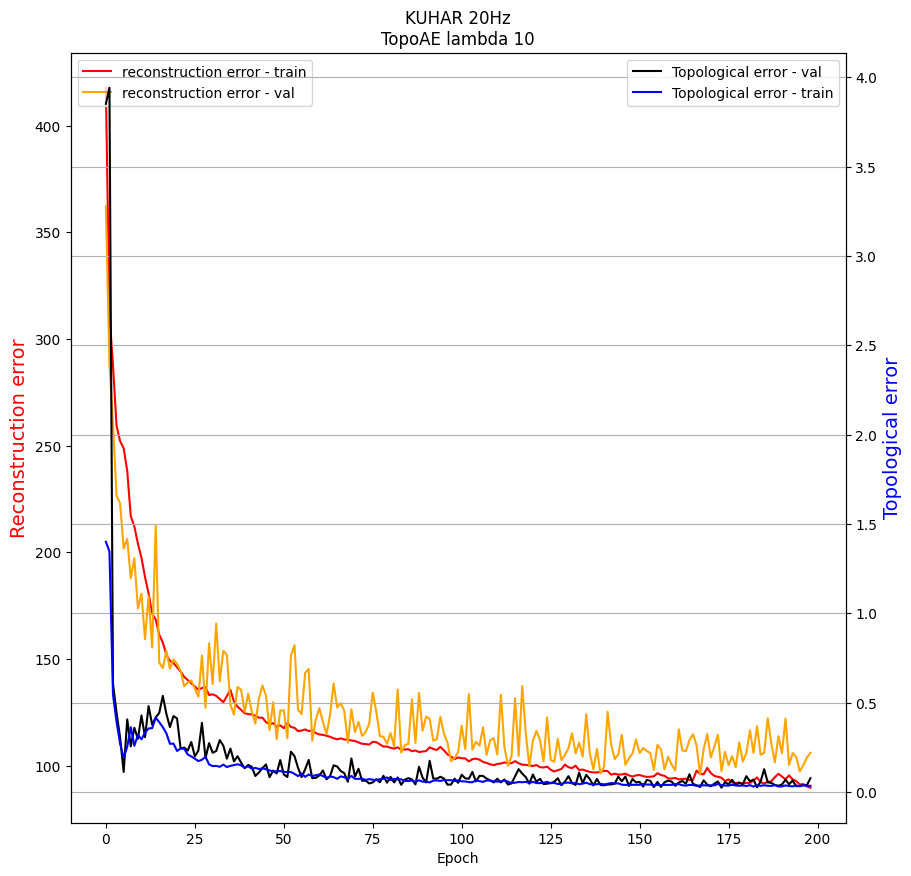

Topologically Regularized DeepAEv2
Using python to compute signatures
DeepAEv2, Input: (1, 180) Inner dim: 2
Epoch:1, P:30, Loss:274.0617, Loss-ae:263.7612, Loss-topo:1.0301
Epoch:2, P:30, Loss:250.0718, Loss-ae:241.4950, Loss-topo:0.8577
Epoch:3, P:30, Loss:265.0501, Loss-ae:256.8199, Loss-topo:0.8230
Epoch:4, P:29, Loss:222.3179, Loss-ae:217.2474, Loss-topo:0.5070
Epoch:5, P:30, Loss:220.2452, Loss-ae:219.0183, Loss-topo:0.1227
Epoch:6, P:30, Loss:234.8261, Loss-ae:230.7517, Loss-topo:0.4074
Epoch:7, P:29, Loss:215.8035, Loss-ae:212.3411, Loss-topo:0.3462
Epoch:8, P:30, Loss:215.8169, Loss-ae:211.0722, Loss-topo:0.4745
Epoch:9, P:29, Loss:179.4571, Loss-ae:176.6010, Loss-topo:0.2856
Epoch:10, P:30, Loss:194.2046, Loss-ae:187.7324, Loss-topo:0.6472
Epoch:11, P:29, Loss:172.5178, Loss-ae:169.4255, Loss-topo:0.3092
Epoch:12, P:30, Loss:169.7637, Loss-ae:167.0479, Loss-topo:0.2716
Epoch:13, P:30, Loss:188.6922, Loss-ae:182.3322, Loss-topo:0.6360
Epoch:14, P:29, Loss:167.9765, Loss-ae:163

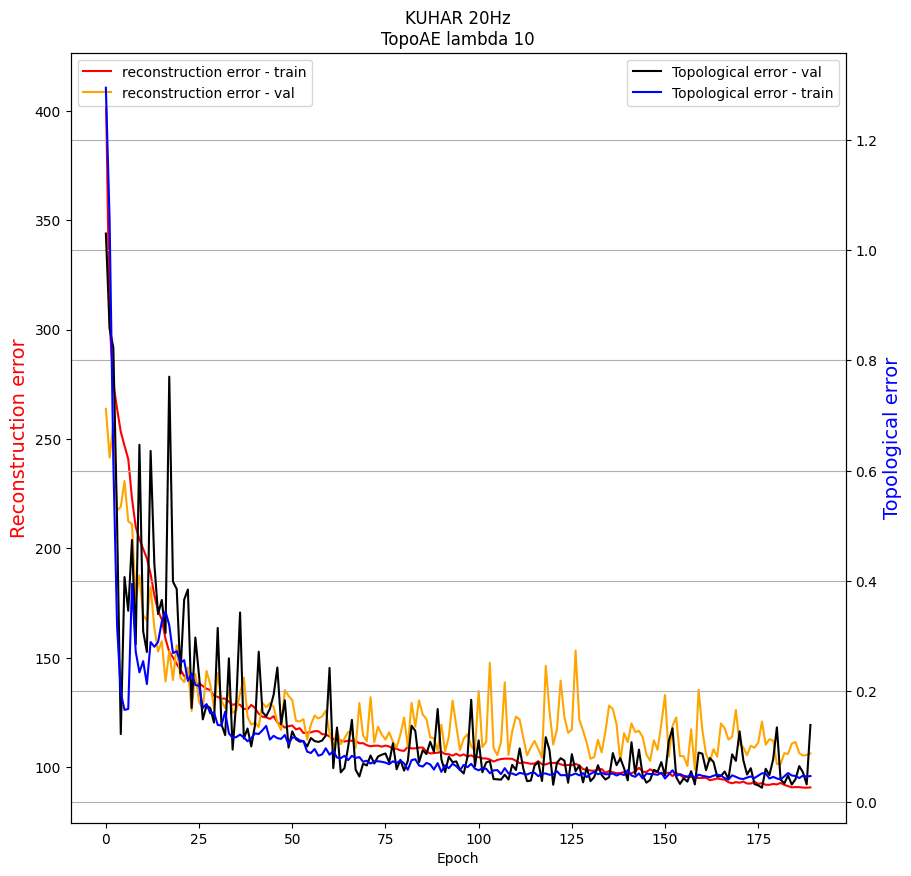

Topologically Regularized DeepAEv2
Using python to compute signatures
DeepAEv2, Input: (1, 180) Inner dim: 2
Epoch:1, P:30, Loss:347.1650, Loss-ae:309.9233, Loss-topo:3.7242
Epoch:2, P:30, Loss:355.2837, Loss-ae:324.7292, Loss-topo:3.0554
Epoch:3, P:29, Loss:243.6877, Loss-ae:240.4146, Loss-topo:0.3273
Epoch:4, P:30, Loss:218.0405, Loss-ae:214.7027, Loss-topo:0.3338
Epoch:5, P:30, Loss:230.9171, Loss-ae:229.3665, Loss-topo:0.1551
Epoch:6, P:29, Loss:242.2917, Loss-ae:231.9251, Loss-topo:1.0367
Epoch:7, P:28, Loss:220.1605, Loss-ae:211.6389, Loss-topo:0.8522
Epoch:8, P:27, Loss:178.3318, Loss-ae:175.8506, Loss-topo:0.2481
Epoch:9, P:30, Loss:172.9261, Loss-ae:170.0408, Loss-topo:0.2885
Epoch:10, P:30, Loss:174.1455, Loss-ae:170.5423, Loss-topo:0.3603
Epoch:11, P:29, Loss:179.9399, Loss-ae:174.4614, Loss-topo:0.5478
Epoch:12, P:28, Loss:205.0776, Loss-ae:199.4604, Loss-topo:0.5617
Epoch:13, P:27, Loss:149.8082, Loss-ae:146.3158, Loss-topo:0.3492
Epoch:14, P:30, Loss:179.5649, Loss-ae:173

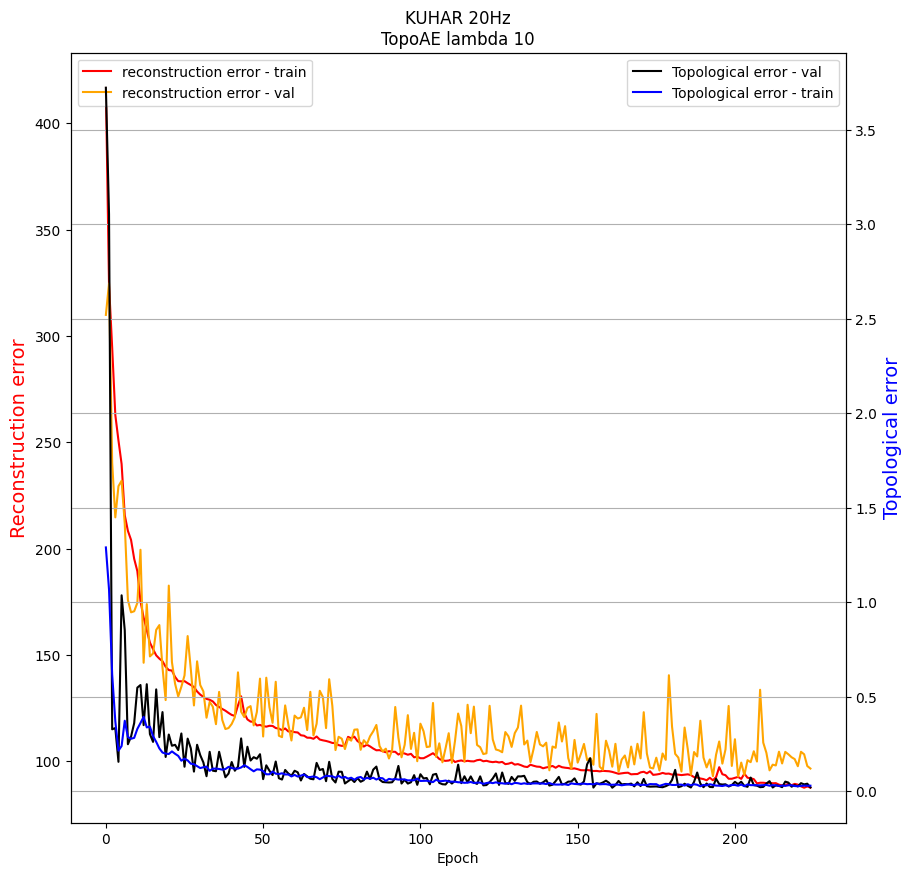

In [13]:
plot_object = {
    'RF-ACC': [],
    'RF-F1': [],
    'SVC-ACC': [],
    'SVC-F1': [],
    'KNN-ACC': [],
    'KNN-F1': [],
    'Trustworthiness': [],
    'Continuity': [],
    'Co-k-NNs': []   
}

for lambda_val in lambdas_to_explore:
    lambda_exploration = explore_lambda(
        train_HD, train_Y,
        test_HD, test_Y,
        lambda_val,
        times_to_execute=executions_per_model
    )
    # print(lambda_val, lambda_exploration)
    for obj_property in plot_object:
        plot_object[obj_property].append(lambda_exploration[obj_property])
    
# print(plot_object)

In [14]:
data_test = plot_object.copy()
for obj_property in plot_object:
    data_test[obj_property] = np.mean(plot_object[obj_property])
data_test

{'RF-ACC': 0.5768959435626102,
 'RF-F1': 0.5849427180849612,
 'SVC-ACC': 0.5094062316284539,
 'SVC-F1': 0.5423352430612519,
 'KNN-ACC': 0.5558495002939448,
 'KNN-F1': 0.5580874855788126,
 'Trustworthiness': 0.905629553023048,
 'Continuity': 0.960977485012732,
 'Co-k-NNs': 0.4854479811376364}

In [22]:
{'RF-ACC': 0.5768959435626102,
 'RF-F1': 0.5849427180849612,
 'SVC-ACC': 0.5094062316284539,
 'SVC-F1': 0.5423352430612519,
 'KNN-ACC': 0.5558495002939448,
 'KNN-F1': 0.5580874855788126,
 'Trustworthiness': 0.905629553023048,
 'Continuity': 0.960977485012732,
 'Co-k-NNs': 0.4854479811376364}

{'RF-ACC': 0.5768959435626102,
 'RF-F1': 0.5849427180849612,
 'SVC-ACC': 0.5094062316284539,
 'SVC-F1': 0.5423352430612519,
 'KNN-ACC': 0.5558495002939448,
 'KNN-F1': 0.5580874855788126,
 'Trustworthiness': 0.905629553023048,
 'Continuity': 0.960977485012732,
 'Co-k-NNs': 0.4854479811376364}

In [15]:
{'RF-ACC': 0.5380952380952382, 'RF-F1': 0.5443698011442134, 'SVC-ACC': 0.544973544973545, 'SVC-F1': 0.5628392356432367, 'KNN-ACC': 0.5105820105820106, 'KNN-F1': 0.514680863841251, 'Trustworthiness': 0.9114767408539497, 'Continuity': 0.9579472729009456, 'Co-k-NNs': 0.4925397877984085}

{'RF-ACC': 0.5380952380952382,
 'RF-F1': 0.5443698011442134,
 'SVC-ACC': 0.544973544973545,
 'SVC-F1': 0.5628392356432367,
 'KNN-ACC': 0.5105820105820106,
 'KNN-F1': 0.514680863841251,
 'Trustworthiness': 0.9114767408539497,
 'Continuity': 0.9579472729009456,
 'Co-k-NNs': 0.4925397877984085}

In [16]:
plot_object_saved = {'RF-ACC': [(0.5325396825396826, 0.5325396825396826, 0.5325396825396826)], 'RF-F1': [(0.5306459717103503, 0.5306459717103503, 0.5306459717103503)], 'SVC-ACC': [(0.4973544973544973, 0.4973544973544973, 0.4973544973544973)], 'SVC-F1': [(0.5321613682690389, 0.5321613682690389, 0.5321613682690389)], 'KNN-ACC': [(0.5132275132275133, 0.5132275132275133, 0.5132275132275133)], 'KNN-F1': [(0.5105974472617104, 0.5105974472617104, 0.5105974472617104)], 'Trustworthiness': [(0.9084040243355842, 0.9084040243355842, 0.9084040243355842)], 'Continuity': [(0.9563854273055248, 0.9563854273055248, 0.9563854273055248)], 'Co-k-NNs': [(0.47529840848806365, 0.47529840848806365, 0.47529840848806365)]}
plot_object_saved

{'RF-ACC': [(0.5325396825396826, 0.5325396825396826, 0.5325396825396826)],
 'RF-F1': [(0.5306459717103503, 0.5306459717103503, 0.5306459717103503)],
 'SVC-ACC': [(0.4973544973544973, 0.4973544973544973, 0.4973544973544973)],
 'SVC-F1': [(0.5321613682690389, 0.5321613682690389, 0.5321613682690389)],
 'KNN-ACC': [(0.5132275132275133, 0.5132275132275133, 0.5132275132275133)],
 'KNN-F1': [(0.5105974472617104, 0.5105974472617104, 0.5105974472617104)],
 'Trustworthiness': [(0.9084040243355842,
   0.9084040243355842,
   0.9084040243355842)],
 'Continuity': [(0.9563854273055248, 0.9563854273055248, 0.9563854273055248)],
 'Co-k-NNs': [(0.47529840848806365, 0.47529840848806365, 0.47529840848806365)]}

## Plot ALL means

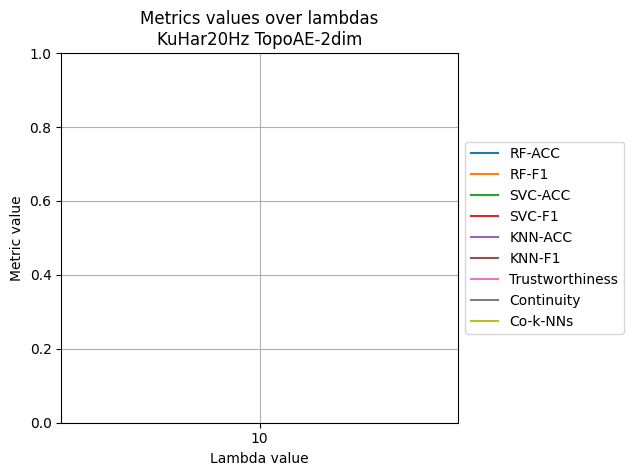

In [17]:
data_x = range(len(lambdas_to_explore))
plt.xticks(data_x, [str(val) for val in lambdas_to_explore])
for obj_property in plot_object:
    data_y = [val[1] for val in plot_object[obj_property]]
    plt.plot(data_x, data_y, label=obj_property)

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Metrics values over lambdas\nKuHar20Hz TopoAE-2dim')
plt.xlabel('Lambda value')
plt.ylabel('Metric value')
plt.grid()
plt.ylim((0, 1))
plt.show()

## Plot Metrics

In [18]:
def plot_properties(plot_object, lambdas_to_explore, properties_to_plot):
    fig, ax = plt.subplots()
    data_x = range(len(lambdas_to_explore))
    plt.xticks(data_x, [str(val) for val in lambdas_to_explore])
    for obj_property in properties_to_plot:
        mean_y = [val[1] for val in plot_object[obj_property]]
        min_y = [val[0] for val in plot_object[obj_property]]
        max_y = [val[2] for val in plot_object[obj_property]]
        ax.plot(data_x, mean_y, label=obj_property)
        ax.fill_between(data_x, min_y, max_y, alpha=0.2)

    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title('Metrics values over lambdas\nKuHar20Hz TopoAE-2dim')
    plt.xlabel('Lambda value')
    plt.ylabel('Metric value')
    plt.grid()
    plt.ylim((0, 1))
    plt.show()

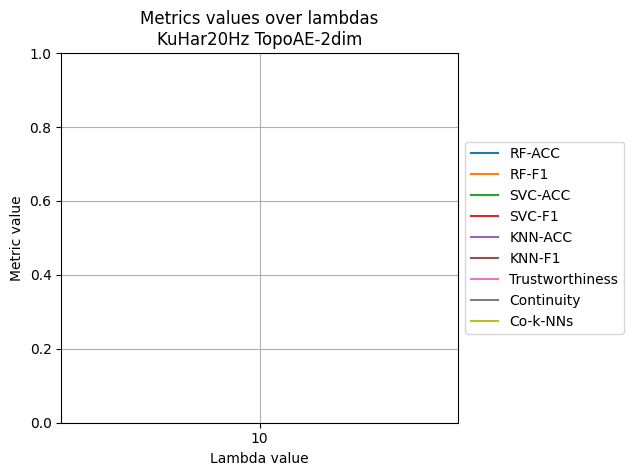

In [19]:
properties_to_plot = [
    'RF-ACC', 'RF-F1',
    'SVC-ACC', 'SVC-F1',
    'KNN-ACC', 'KNN-F1',
    'Trustworthiness',
    'Continuity',
    'Co-k-NNs'
]
plot_properties(plot_object, lambdas_to_explore, properties_to_plot)

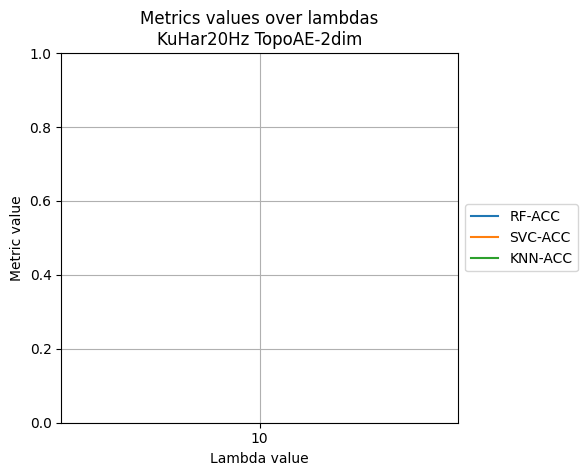

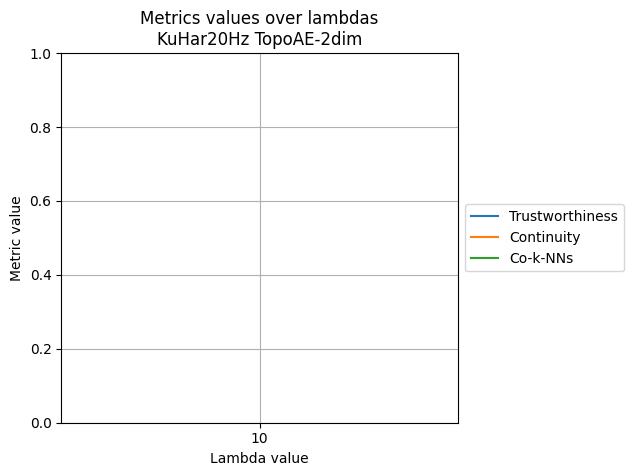

In [20]:
properties_to_plot = [
    'RF-ACC',
    'SVC-ACC',
    'KNN-ACC'
]
plot_properties(plot_object, lambdas_to_explore, properties_to_plot)
properties_to_plot = [
    'Trustworthiness',
    'Continuity',
    'Co-k-NNs'
]
plot_properties(plot_object, lambdas_to_explore, properties_to_plot)

In [21]:
assert 1 ==0
asda = {'asd': [2, 3], 'asdasd': [3,4,5]}
for i in asda:
    asda[i] = np.mean(asda[i])
print(asda)

AssertionError: 

In [ ]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 10000
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

In [ ]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['Topo-AEv2 (L=10000)'][0] = experiments_result['RF-ACC']
table_info['Topo-AEv2 (L=10000)'][1] = experiments_result['RF-F1']
table_info['Topo-AEv2 (L=10000)'][2] = experiments_result['SVC-ACC']
table_info['Topo-AEv2 (L=10000)'][3] = experiments_result['SVC-F1']
table_info['Topo-AEv2 (L=10000)'][4] = experiments_result['KNN-ACC']
table_info['Topo-AEv2 (L=10000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['Topo-AEv2 (L=10000)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=10000)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=10000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** UMAP

In [ ]:
umap_reducer = UMAP()
umap_reducer.fit(train_HD, train_Y)

In [ ]:
train_LD = np.reshape(umap_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(umap_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['UMAP'][0] = experiments_result['RF-ACC']
table_info['UMAP'][1] = experiments_result['RF-F1']
table_info['UMAP'][2] = experiments_result['SVC-ACC']
table_info['UMAP'][3] = experiments_result['SVC-F1']
table_info['UMAP'][4] = experiments_result['KNN-ACC']
table_info['UMAP'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['UMAP'][6] = metrics_report['trustworthiness']
table_info['UMAP'][7] = metrics_report['continuity']
table_info['UMAP'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Metrics AE (metric=coknns, lambda=1000)

In [ ]:
from librep.transforms.adapted_ae import AdaptedAEDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import MetricsRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
mae_lambda = 1000
mae_reducer = AdaptedAEDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam=mae_lambda,
    metric='coknns',
    ae_kwargs=kwargs,
    input_shape=input_shape,
    patience=10
)

In [ ]:
title_plot = "KUHAR 20Hz\nAdaptedAE lambda " + str(mae_lambda)
mae_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(mae_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(mae_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['M-AE (L=1000)'][0] = experiments_result['RF-ACC']
table_info['M-AE (L=1000)'][1] = experiments_result['RF-F1']
table_info['M-AE (L=1000)'][2] = experiments_result['SVC-ACC']
table_info['M-AE (L=1000)'][3] = experiments_result['SVC-F1']
table_info['M-AE (L=1000)'][4] = experiments_result['KNN-ACC']
table_info['M-AE (L=1000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['M-AE (L=1000)'][6] = metrics_report['trustworthiness']
table_info['M-AE (L=1000)'][7] = metrics_report['continuity']
table_info['M-AE (L=1000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Metrics AE (metric=coknns, lambda=10000)

In [ ]:
from librep.transforms.adapted_ae import AdaptedAEDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import MetricsRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
mae_lambda = 10000
mae_reducer = AdaptedAEDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam=mae_lambda,
    metric='coknns',
    ae_kwargs=kwargs,
    input_shape=input_shape,
    patience=10
)

In [ ]:
title_plot = "KUHAR 20Hz\nAdaptedAE lambda " + str(mae_lambda)
mae_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(mae_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(mae_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['M-AE (L=10000)'][0] = experiments_result['RF-ACC']
table_info['M-AE (L=10000)'][1] = experiments_result['RF-F1']
table_info['M-AE (L=10000)'][2] = experiments_result['SVC-ACC']
table_info['M-AE (L=10000)'][3] = experiments_result['SVC-F1']
table_info['M-AE (L=10000)'][4] = experiments_result['KNN-ACC']
table_info['M-AE (L=10000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['M-AE (L=10000)'][6] = metrics_report['trustworthiness']
table_info['M-AE (L=10000)'][7] = metrics_report['continuity']
table_info['M-AE (L=10000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run